# 3D Partially coherent ODT forward simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftn, ifftn

import pickle
import waveorder as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
N           = 256                 # number of pixel in y dimension
M           = 256                 # number of pixel in x dimension
L           = 100                 # number of layers in z dimension
n_media     = 1.46                # refractive index in the media
mag         = 63                  # magnification
ps          = 6.5/mag             # effective pixel size
psz         = 0.25                # axial pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 1.2                 # objective NA
NA_illu     = 0.9                 # illumination NA

### Sample creation

In [4]:
radius = 5
blur_size = 2*ps
sphere, _, _ = wo.gen_sphere_target((N,M,L), ps, psz, radius, blur_size)
wo.image_stack_viewer(np.transpose(sphere,(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [5]:
# Physical value assignment

n_sample = 1.50 

RI_map = np.zeros_like(sphere)
RI_map[sphere > 0] = sphere[sphere > 0]*(n_sample-n_media)
RI_map += n_media
t_obj = np.exp(1j*2*np.pi*psz*(RI_map-n_media))


In [6]:
wo.image_stack_viewer(np.transpose(np.angle(t_obj),(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

### Setup acquisition

In [7]:
# Subsampled Source pattern

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Source_cont = wo.gen_Pupil(fxx, fyy, NA_illu, lambda_illu)


Source_discrete = wo.Source_subsample(Source_cont, lambda_illu*fxx, lambda_illu*fyy, subsampled_NA = 0.1)

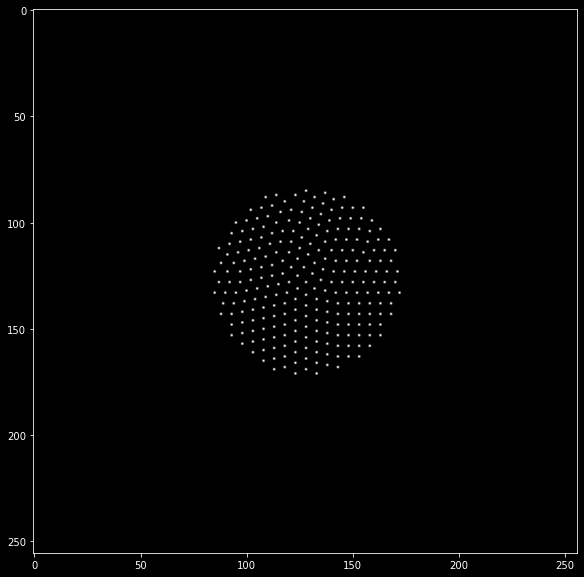

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(fftshift(Source_discrete),cmap='gray')


In [9]:
np.sum(Source_discrete)

253.0

In [10]:
z_defocus = (np.r_[:L]-L//2)*psz
chi = 0.1*2*np.pi
setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, phase_deconv='3D', illu_mode='Arbitrary', Source=Source_cont)

simulator = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, illu_mode='Arbitrary', Source=Source_discrete)


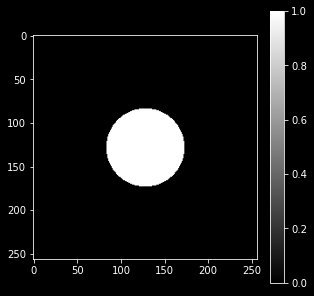

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(fftshift(setup.Source), cmap='gray')
plt.colorbar()

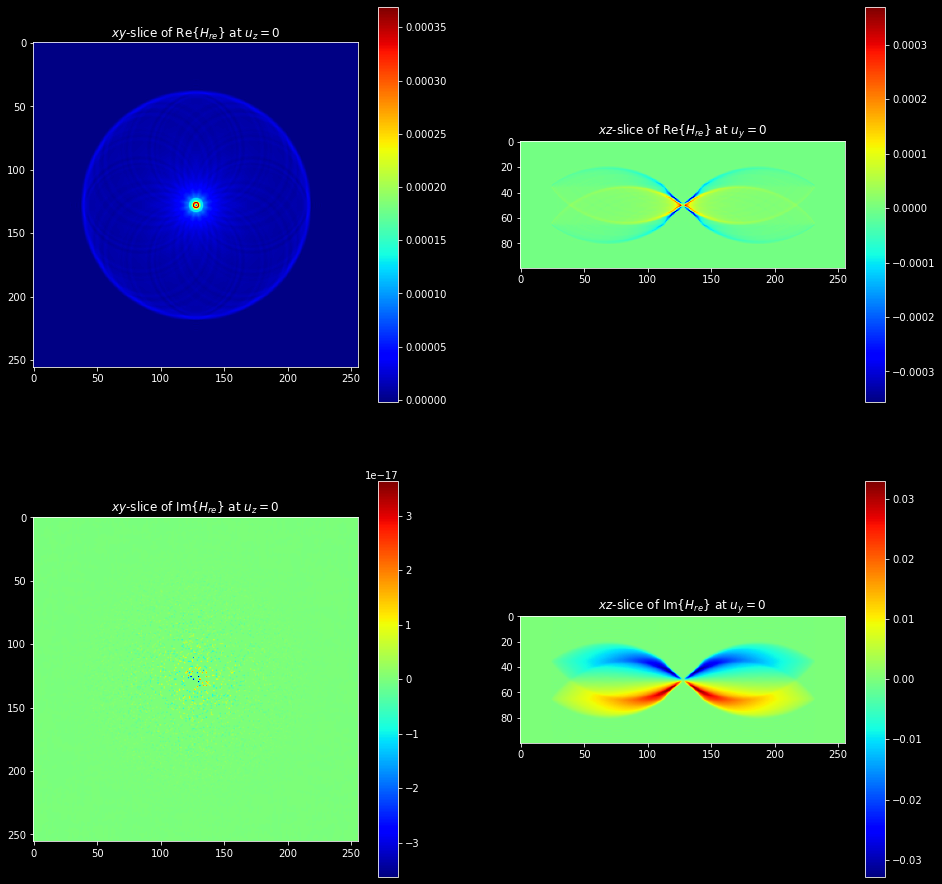

In [12]:
H_re_vis = fftshift(setup.H_re)

wo.plot_multicolumn([np.real(H_re_vis)[:,:,L//2], np.transpose(np.real(H_re_vis)[N//2,:,:]), \
                     np.imag(H_re_vis)[:,:,L//2], np.transpose(np.imag(H_re_vis)[N//2,:,:])], \
                    num_col=2, size=8, set_title=True, \
                    titles=['$xy$-slice of Re{$H_{re}$} at $u_z=0$', '$xz$-slice of Re{$H_{re}$} at $u_y=0$', \
                            '$xy$-slice of Im{$H_{re}$} at $u_z=0$', '$xz$-slice of Im{$H_{re}$} at $u_y=0$'], colormap='jet')

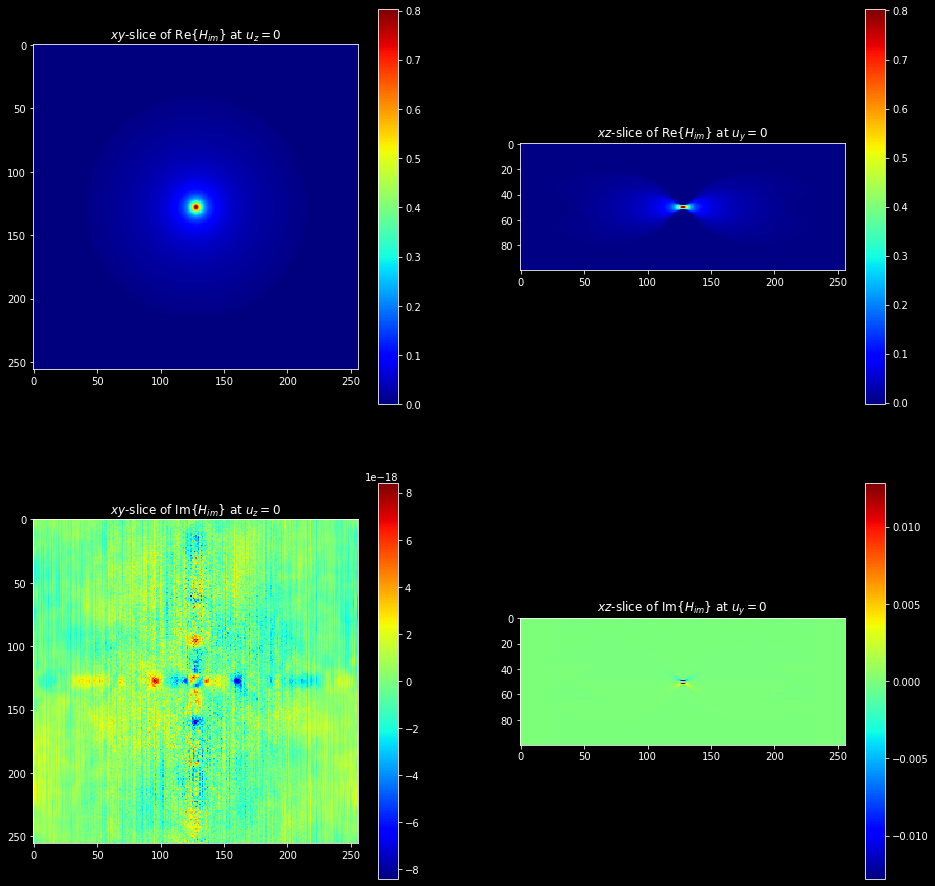

In [15]:
H_im_vis = fftshift(setup.H_im)

wo.plot_multicolumn([np.real(H_im_vis)[:,:,L//2], np.transpose(np.real(H_im_vis)[N//2,:,:]), \
                     np.imag(H_im_vis)[:,:,L//2], np.transpose(np.imag(H_im_vis)[N//2,:,:])], \
                    num_col=2, size=8, set_title=True, \
                    titles=['$xy$-slice of Re{$H_{im}$} at $u_z=0$', '$xz$-slice of Re{$H_{im}$} at $u_y=0$', \
                            '$xy$-slice of Im{$H_{im}$} at $u_z=0$', '$xz$-slice of Im{$H_{im}$} at $u_y=0$'], colormap='jet')

In [13]:
I_meas = simulator.simulate_3D_scalar_measurements(t_obj)

Number of point sources considered (100 / 253) in pattern (1 / 1), elapsed time: 42.66
Number of point sources considered (200 / 253) in pattern (1 / 1), elapsed time: 85.29
Number of point sources considered (253 / 253) in pattern (1 / 1), elapsed time: 107.92


In [12]:
wo.image_stack_viewer(np.transpose(np.abs(I_meas),(0,1,2)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=255), Output()), _dom_classes=('widget-i…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [18]:
# Save simulations

output_file = '3D_PODT_simulation'

np.savez(output_file, I_meas=I_meas, lambda_illu=lambda_illu, \
                      n_media=n_media, NA_obj=NA_obj, NA_illu=NA_illu, ps=ps, psz=psz, Source_cont=Source_cont)

